## Autores

Carlos Augusto Jardim Chiarelli **165685**

Lucas **9999**

$$ $$

## ES728 – Controle Avançado de Sistemas

### *Curso Verão 2021 - Prof. Ely Paiva*

$$ $$

# Projeto Final – **Controle LQR de um Pêndulo Invertido**

Será utilizado controle LQR e um observador de estados.

$$ $$

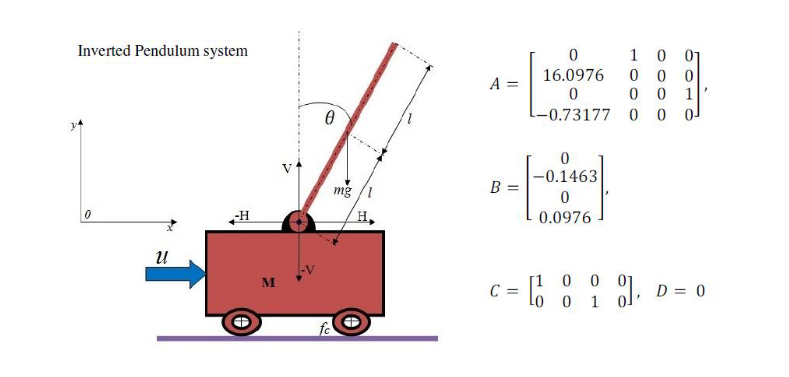

In [1]:
from IPython.display import Image
Image('../img/01_final.png')

In [2]:
from numpy.linalg import inv, eig, lstsq
from numpy.linalg import matrix_rank as rank
from numpy import array, eye, dot, zeros, poly, ones, pi
from numpy import roots, arange, asarray, concatenate, linspace
from functools import reduce
import matplotlib.pyplot as plt
from control import acker, place, ss, forced_response, lqr, care
from control import obsv, ctrb, minreal, tf, ss2tf, tf2ss, impulse_response
from scipy.signal import square
import pandas as pd
import seaborn as sns


def mul_mat(*args):
    return reduce(dot, args)


def plota_resp(T,
               yout,
               titulo,
               xlabel='Tempos (s)',
               ylabel='Altura da bolinha (m)\n'):

    plt.plot(T, yout)
    plt.title(titulo + '\n')
    plt.xlabel('\n' + xlabel)
    plt.ylabel(ylabel + '\n')
    plt.grid(alpha=.5)
    plt.show()
    
    
def plota_resp2(T,
               yout,
               titulo,
               legend_lab=['var1', 'var2'],
               xlabel='Tempos (s)',
               ylabel='Altura da bolinha (m)\n',
               xlim=None):

    plt.plot(T, yout[0], 'b--', label=legend_lab[0])
    plt.plot(T, yout[1], 'r', label=legend_lab[1])
    if xlim:
        plt.xlim(xlim)
        
    plt.title(titulo + '\n')
    plt.xlabel('\n' + xlabel)
    plt.ylabel(ylabel + '\n')
    plt.grid(alpha=.5)
    plt.legend()
    plt.show()    
    
    
def plota_resp_sist2(t, yout, ylabels=["x1", "x3"],
                     titulo='Resposta ao degrau', xlabel='Tempo (s)',
                    u=None):
    
    plt.rcParams["figure.figsize"] = (11,7)
    
    fig, axes = plt.subplots(2, 1)

    fig.suptitle(titulo+'\n')
    
    for num, ax in enumerate(axes.flatten()):
        ax.axhline(y=0, color='black', linestyle='--', alpha=.5)
        if u is not None:
            if ylabels[num] == "posição (m)":
                ax.plot(T, u_square, color='skyblue', label='entrada')
                plt.legend()
        ax.plot(T, yout[num], color='b')
        ax.set_ylabel(ylabels[num]+'\n')
        ax.grid(alpha=.5)

    plt.xlabel('\n'+xlabel)
        
    fig.tight_layout()
    plt.show()        


def plota_obs(T, xout):
    
    aux = xout.T
    n = 4
    e = aux[:, n:]
    x = aux[:, :n]
    x_est = x-e
    
    theta = x[:,0]
    theta_dot = x[:,1]
    x_pos = x[:,2]
    x_pos_dot = x[:,3]

    theta_est = x_est[:,0]
    theta_dot_est = x_est[:,1]
    x_pos_est = x_est[:,2]
    x_pos_dot_est = x_est[:,3]
    

    fig, ax = plt.subplots(2, 1)

    ax[0].plot(T,theta,'-y', label='theta')
    ax[0].plot(T,theta_est,':b', label='theta_est')
    ax[0].plot(T,theta_dot,'-g', label='theta_dot')
    ax[0].plot(T,theta_dot_est,':r', label='theta_dot_est')
    ax[0].grid(alpha=.4)
    ax[0].legend(loc="lower right")

    ax[1].plot(T,x_pos,'-y', label='x_pos')
    ax[1].plot(T,x_pos_est,':b', label='x_pos_est')
    ax[1].plot(T,x_pos_dot,'-g', label='x_pos_dot')
    ax[1].plot(T,x_pos_dot_est,':r', label='x_pos_dot_est')
    ax[1].grid(alpha=.4)
    ax[1].legend(loc="lower right")

    plt.xlabel('\nTempo (s)')
    #plt.title("'Est' é o parâmetro estimado\n")
    fig.suptitle("Controle com Observador\n('Est' é o estado estimado)")
    #plt.grid(alpha=.4)
    plt.show()
        
    
def inv2(m):
    a, b = m.shape
    if a != b:
        raise ValueError("Only square matrices are invertible.")

    i = eye(a, a)
    return lstsq(m, i)[0]


class Systems():
    
    def __init__(self, parametros: list):
        """
        :param parametros: Dict no template [{'Q11':1, 'Q33':10, 'R':5}, {'Q11':100, 'Q33':1, 'R':1}, {'Q11':1, 'Q33':1, 'R':999}]
        """
        self.Qc = None
        self.R = None
        self.params = parametros
        self.sys = {}
    
    def reset_params(self):
        self.Qc = dot(C.T, C)
        self.R = 1
    
    def set_param(self, param: dict):
        self.Qc[0,0] = param['Q11']
        self.Qc[2,2] = param['Q33']    
        self.R = param['R']
        
        return f'Q11 {self.Qc[0,0]}, Q33 {self.Qc[2,2]}, R {self.R}'
    
    def get_new_sys(self):
        """Apenas LQR."""
        K, S, E  = lqr(A, B, self.Qc, self.R)

        Ac = A-dot(B,K)
        Bc = B
        Cc = C
        Dc = D
        
        sys_ss = ss(Ac,Bc,Cc,Dc2)
        
        return sys_ss

    def get_new_sys_obs(self):
        """LQR + Obs."""
        K, S, E  = lqr(A, B, self.Qc, self.R)

#         Q = obsv(A, [0, 0, 1, 0])
#         iQ = inv(Q)
#         q = iQ[:,3]
#         QQ = array([q, mul_mat(A,q), mul_mat(A,A,q), mul_mat(A,A,A,q)]).T
#         T = QQ.copy()
#         Ao = mul_mat(inv(T), A, T)
#         Bo = dot(inv(T), B)
#         Co = dot(C, T)

        # Nbar
        Cn = array([[0, 0, 1, 0]])
        Dn = array([[0]])
        a1_ = concatenate((A, B), axis=1)
        a2_ = concatenate((Cn, Dn), axis=1)
        AA = concatenate((a1_, a2_), axis=0)

        # set point é 0.2
        rss = 0.2
        t = array([[0, 0, 0, 0, rss]]).T
        ux = dot(inv2(AA),t)
        xss = aux[0:4,:]
        uss = aux[4,:]
        Nx = xss/rss
        Nu = uss/rss
        Nbar = Nu + dot(K,Nx)
        Nbar = float(Nbar)

        # construindo At
        a11 = A - dot(B,K)
        a12 = dot(B,K)
        a21 = zeros(A.shape)
        a22 = A - dot(L2.T,Cn)
        a1_ = concatenate((a11, a12), axis=1)
        a2_ = concatenate((a21, a22), axis=1)
        Ace = concatenate((a1_, a2_), axis=0)
        # construindo Bt
        b11 = B*Nbar
        b21 = zeros(B.shape)
        Bce = concatenate((b11, b21), axis=0)
        # construindo Ct
        c11 = C
        c12 = zeros(C.shape)
        Cce = concatenate((c11, c12), axis=1)
        # Dt
        Dc2 = 0
        
        sys_ss = ss(Ace,Bce,Cce,Dc2)

        return sys_ss
    
    def run(self, obs=True):
        for param in self.params:
            self.reset_params()
            label = self.set_param(param)
            
            if obs:
                sys = self.get_new_sys_obs()
            else:
                sys = self.get_new_sys()
                
            self.sys.update({label:sys})
        
        return self.sys
    

class Responses():
    
    def __init__(self, sys: dict):
        """
        :para, sys: Dict que contém os sistemas que serão testas sob as respostas.
        """
        self.sys = sys
        self.step = {}
        self.ci = {}
        self.wave = {}
        self.t = arange(0, 30, .01)
        self.Dc2 = 0
        self.xo = [0.1, 0, 1, 0, 0, 0, 0, 0]
        self.t_square = arange(0, 180, 0.1)
        self.u_square = square(2 * pi * 1/90 * self.t_square)    
    
    def run(self):
        for label, sys in self.sys.items():
            T, yout, xout = forced_response(sys, self.t, U=0.2)
            self.step.update({label:{'T':T, 'yout0':yout[0], 'yout1':yout[1]}})
            
            T, yout = impulse_response(sys, T=self.t, X0=self.xo)
            self.ci.update({label:{'T':T, 'yout0':yout[0], 'yout1':yout[1]}})
            
            T, yout, xout = forced_response(sys, self.t_square, U=self.u_square)
            self.wave.update({label:{'T':T, 'yout0':yout[0], 'yout1':yout[1]}})
        
        return {'step': self.step, 'ci': self.ci, 'wave': self.wave}
        
        
class TidyData():
    
    def __init__(self, resp: dict):
        """
        :param resp: Dict que contém as respostas dos sistemas.
        """    
        self.resp = resp
        self.final = {'step': None, 'ci': None, 'wave': None}
    
    def tidy(self, name_resp: str):
        """:param name_resp: Str que seja ['step', 'ci' ou 'wave']."""
        resp_target = self.resp[name_resp]

        primeiro = True

        for label, values in resp_target.items():

            df_aux = pd.DataFrame(values)
            df_aux['label'] = label

            if primeiro:
                df = df_aux.copy()
                primeiro = False
            else:
                df = pd.concat([df, df_aux])

            #print(df.shape)
        
        self.final[name_resp] = df
    
    def run(self) -> dict:
        for resposta in ['step', 'ci', 'wave']:
            self.tidy(resposta)
        
        return self.final        

    
class Visualizacao():
    
    def __init__(self, resp_df: dict):
        """:param resp_df: Dict com as respostas em pd.DataFrame"""
        sns.set_theme(style="darkgrid")
        sns.set(rc={'figure.figsize':(11.7,8.27), "font.size":16})
        
        self.resp_df = resp_df
        self.resp = None
        self.pos_leg0 = "upper right"
        self.pos_leg1 = "lower right"
        self.titulo = 'Resposta ao degrau (CI nulas)'
    
    def set_param(self, type_resp: str):
        """:param type_resp: Str é o tipo de resposta, exe: ['step', 'ci', 'wave']"""
        self.resp = type_resp
        
        if type_resp == 'step':
            self.pos_leg0 = "upper right"
            self.pos_leg1 = "lower right"
            self.titulo = 'Resposta ao degrau (CI nulas)'      
        elif type_resp == 'ci':
            self.pos_leg0 = "upper right"
            self.pos_leg1 = "upper right"
            self.titulo = 'Resposta ao impulso (CI não nulas)'  
        else:
            self.pos_leg0 = "upper right"
            self.pos_leg1 = "lower right"
            self.titulo = 'Resposta a uma onda quadrada (CI nulas)'              
    
    
    def show(self):
        f, axes = plt.subplots(2, 1)

        sns.lineplot(x='T', y='yout0', hue='label', data=self.resp_df[self.resp], ax=axes[0])
        sns.lineplot(x='T', y='yout1', hue='label', data=self.resp_df[self.resp], ax=axes[1])

        axes[0].legend(loc=self.pos_leg0)
        axes[1].legend(loc=self.pos_leg1)

        axes[0].set_xlabel('')

        axes[0].set_ylabel('θ (rad)'+'\n')
        axes[1].set_ylabel('posição (m)'+'\n')

        f.suptitle(self.titulo+'\n')

        plt.xlabel('\nTempo (s)')
        plt.show()
        
    
# plots config    
plt.rcParams["figure.figsize"] = (11,7)
plt.rcParams.update({'font.size': 15})


$$ $$

## **PRIMEIRA PARTE (vetor de estado conhecido)**

$$ $$

In [3]:
# Modelo de planta utilizado
A = array([[0,        1,  0,  0],
           [16.0976,  0,  0,  0],
           [0,        0,  0,  1],
           [-0.73177, 0,  0,  0]])

B = array([[0, -0.1463, 0, 0.0976]]).T

C = array([[1, 0, 0, 0],
           [0, 0, 1, 0]])

# C2 = array([1, 0, 0, 0],
#            [0, 0, 1, 0])

D = array([[0, 0]]).T


In [4]:
sys_ss = ss(A,B,C,D)

Deig, v = eig(A)

Deig

array([ 0.        ,  0.        ,  4.01218145, -4.01218145])

$$ $$

Possui um pólo positivo, logo o sistema é instável como esperado pois soltando o pêndulo sem controle ele irá cair e parar no chão.

$$ $$

In [5]:
rank(ctrb(A, B))

4

$$ $$

Rank cheio, sistema controlável!

$$ $$

In [6]:
Qc = dot(C.T, C)

Qc

array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0]])

In [7]:
R = 1
K, S, E  = lqr(A, B, Qc, R)

In [8]:
K

matrix([[-244.75328676,  -61.22658528,   -1.        ,   -5.18890327]])

In [9]:
R = 1
P, L, K2 = care(A, B, Qc, R)

In [10]:

(K==K2).all()


True

In [11]:
L

array([-4.0122185 +0.01825039j, -4.0122185 -0.01825039j,
       -0.21328796+0.21319976j, -0.21328796-0.21319976j], dtype=complex64)

In [12]:

Ac = A-dot(B,K)
Bc = B
Cc = C
Dc = D

Ac

matrix([[  0.        ,   1.        ,   0.        ,   0.        ],
        [-19.70980585,  -8.95744943,  -0.1463    ,  -0.75913655],
        [  0.        ,   0.        ,   0.        ,   1.        ],
        [ 23.15615079,   5.97571472,   0.0976    ,   0.50643696]])

In [13]:
Bc

array([[ 0.    ],
       [-0.1463],
       [ 0.    ],
       [ 0.0976]])

In [14]:
Dc

array([[0],
       [0]])

In [15]:

Dc2 = 0

t = arange(0, 30, .01)
sys_ss = ss(Ac,Bc,Cc,Dc2)
T, yout, xout = forced_response(sys_ss, t, U=0.2)


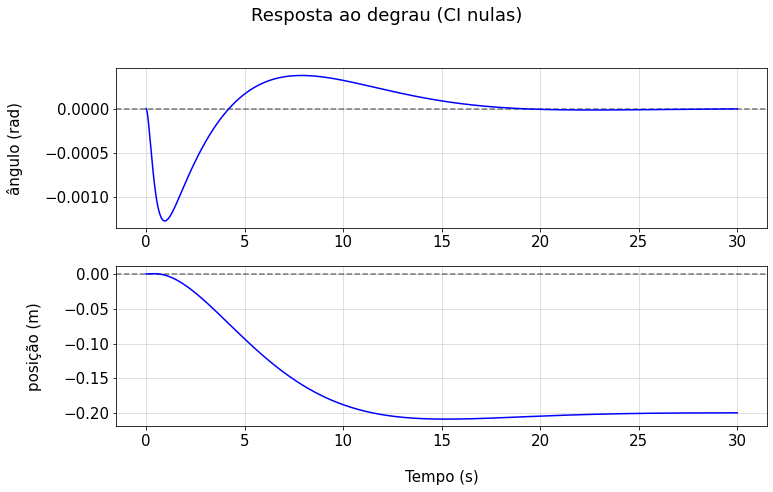

In [16]:

plota_resp_sist2(t, yout,
                 titulo='Resposta ao degrau (CI nulas)',
                 ylabels=['ângulo (rad)', 'posição (m)'])


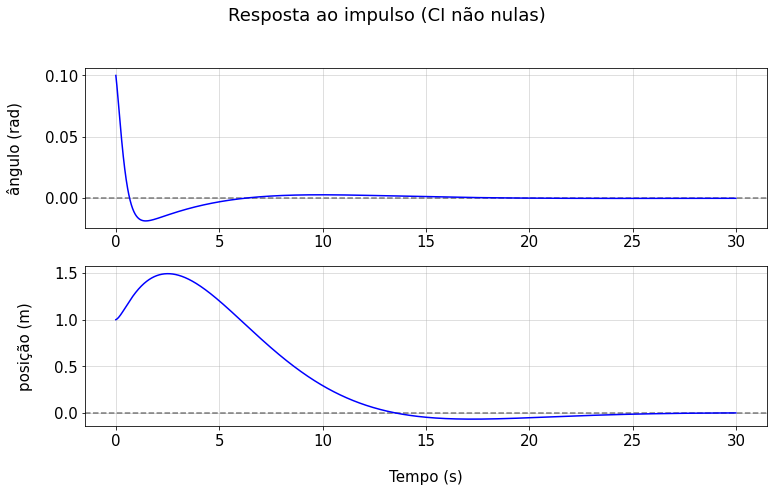

In [17]:

xo = [0.1, 0, 1, 0]

T, yout = impulse_response(sys_ss, T=t, X0=xo)

plota_resp_sist2(T, yout,
                 titulo='Resposta ao impulso (CI não nulas)',
                 ylabels=['ângulo (rad)', 'posição (m)'])


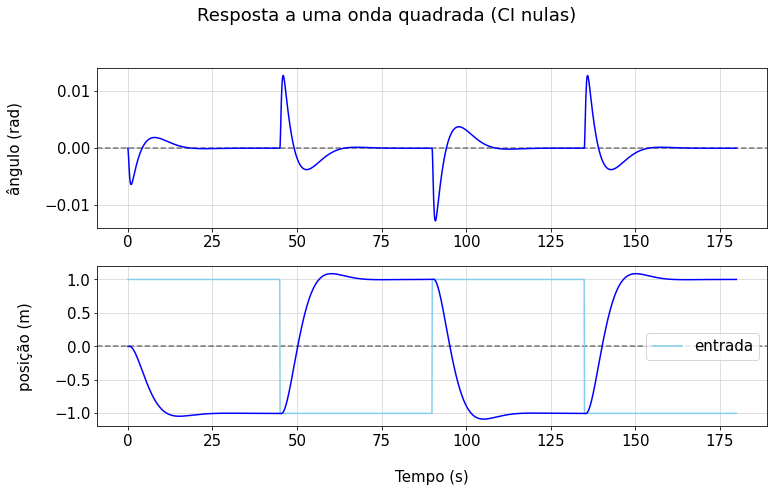

In [18]:

t_square = arange(0, 180, 0.1)
u_square = square(2 * pi * 1/90 * t_square)

T, yout, xout = forced_response(sys_ss, t_square, U=u_square)

plota_resp_sist2(T, yout,
                 titulo='Resposta a uma onda quadrada (CI nulas)',
                 ylabels=['ângulo (rad)', 'posição (m)'],
                 u=u_square)


$$ $$
Acima vemos que a posição segue a entrada com sinal oposto devido a realimentação **K** ser positiva.
$$ $$

$$ $$

## **SEGUNDA PARTE (estado parcialmente conhecido, incluir observador)**

$$ $$

In [19]:
rank(obsv(A, [1, 0, 0, 0]))

2

$$ $$

O rank não é cheio, logo o sistema não é observável!

$$ $$

In [20]:
Q = obsv(A, [0, 0, 1, 0])
rank(Q)

4

$$ $$

Rank cheio, logo o sistema é observável!

$$ $$

In [21]:
iQ = inv(Q)

In [22]:
iQ

matrix([[-0.       , -0.       , -1.3665496, -0.       ],
        [-0.       , -0.       , -0.       , -1.3665496],
        [ 1.       ,  0.       ,  0.       ,  0.       ],
        [ 0.       ,  1.       ,  0.       ,  0.       ]])

In [23]:
iQ[:,3]

matrix([[-0.       ],
        [-1.3665496],
        [ 0.       ],
        [ 0.       ]])

In [24]:
q = iQ[:,3]

QQ = array([q, mul_mat(A,q), mul_mat(A,A,q), mul_mat(A,A,A,q)]).T

T = QQ.copy()

Ao = mul_mat(inv(T), A, T)

Bo = dot(inv(T), B)

Co = dot(C, T)

In [25]:

#Cn = array([[1, 0, 0, 0]])
Cn = array([[0, 0, 1, 0]])

Dn = array([[0]])


In [26]:
D2 = array([D])

a1_ = concatenate((A, B), axis=1)
a2_ = concatenate((Cn, Dn), axis=1)

AA = concatenate((a1_, a2_), axis=0)


In [27]:
AA

array([[ 0.     ,  1.     ,  0.     ,  0.     ,  0.     ],
       [16.0976 ,  0.     ,  0.     ,  0.     , -0.1463 ],
       [ 0.     ,  0.     ,  0.     ,  1.     ,  0.     ],
       [-0.73177,  0.     ,  0.     ,  0.     ,  0.0976 ],
       [ 0.     ,  0.     ,  1.     ,  0.     ,  0.     ]])

In [28]:
# set point é 0.2
rss = 0.2
t = array([[0, 0, 0, 0, rss]]).T

t

array([[0. ],
       [0. ],
       [0. ],
       [0. ],
       [0.2]])

In [29]:
# xss -> 2x1
# uss -> 1x1
# t = [[xss], [uss]]

#aux = dot(inv(AA),t) # matriz singular
aux = dot(inv2(AA),t)

xss = aux[0:4,:]

# valor de controle
uss = aux[4,:]

/home/carlos/Projetos/eng-controle-automacao/06_controle_avancado/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:127: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


$$ $$
A matriz $AA$ é singular, ou seja, não possui inversa. Logo foi utilizada uma técnica para obter a pseudo-inversa da respectiva matriz.
$$ $$

In [30]:
xss

array([[0. ],
       [0. ],
       [0.2],
       [0. ]])

In [31]:
uss

array([0.])

In [32]:

Nx = xss/rss
Nu = uss/rss
Nbar = Nu + dot(K,Nx)

Nbar = float(Nbar)

Nbar

-1.0000000000043265

In [33]:
L2 = array([L])

In [34]:
L.shape, L2.shape, C.shape, Cn.shape

((4,), (1, 4), (2, 4), (1, 4))

In [35]:

# construindo At
a11 = A - dot(B,K)
a12 = dot(B,K)
a21 = zeros(A.shape)
a22 = A - dot(L2.T,Cn)

a1_ = concatenate((a11, a12), axis=1)
a2_ = concatenate((a21, a22), axis=1)

Ace = concatenate((a1_, a2_), axis=0)

# construindo Bt
b11 = B*Nbar
b21 = zeros(B.shape)

Bce = concatenate((b11, b21), axis=0)

# construindo Ct
c11 = C
c12 = zeros(C.shape)

Cce = concatenate((c11, c12), axis=1)


In [36]:
Ace.shape, Bce.shape, Cce.shape

((8, 8), (8, 1), (2, 8))

In [37]:

Dc2 = 0

t = arange(0, 30, .01)
sys_ss = ss(Ace,Bce,Cce,Dc2)
T, yout, xout = forced_response(sys_ss, t, U=0.2)


/home/carlos/Projetos/eng-controle-automacao/06_controle_avancado/.venv/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  return data.astype(dtype)


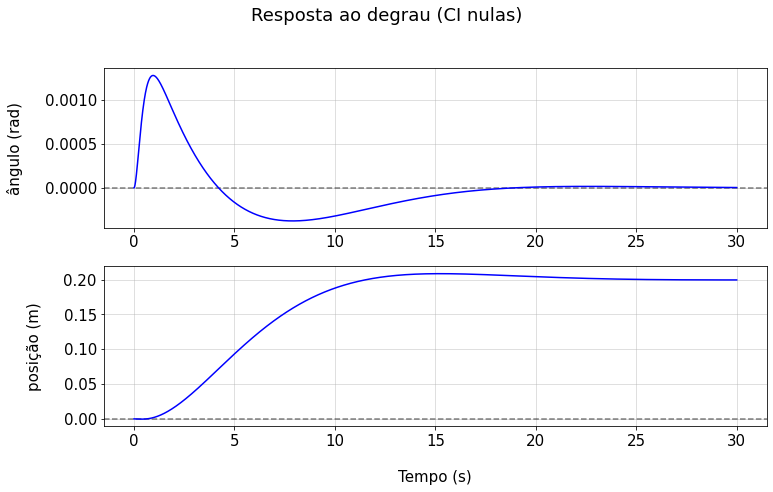

In [38]:

plota_resp_sist2(t, yout,
                 titulo='Resposta ao degrau (CI nulas)',
                 ylabels=['ângulo (rad)', 'posição (m)'])


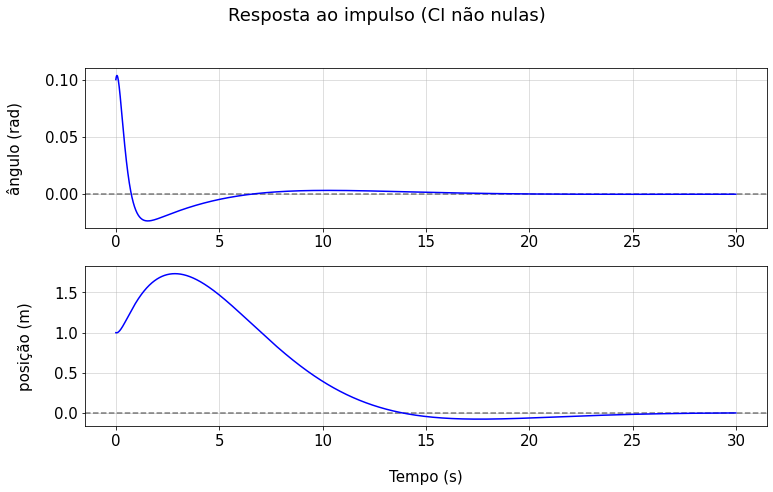

In [39]:

xo = [0.1, 0, 1, 0, 0, 0, 0, 0]

T, yout = impulse_response(sys_ss, T=t, X0=xo)

plota_resp_sist2(T, yout,
                 titulo='Resposta ao impulso (CI não nulas)',
                 ylabels=['ângulo (rad)', 'posição (m)'])


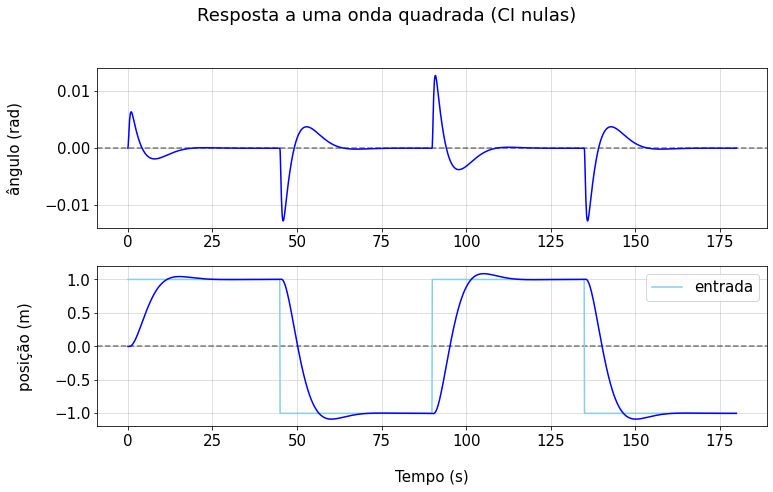

In [40]:

T, yout, xout = forced_response(sys_ss, t_square, U=u_square)

plota_resp_sist2(T, yout,
                 titulo='Resposta a uma onda quadrada (CI nulas)',
                 ylabels=['ângulo (rad)', 'posição (m)'],
                 u=u_square)


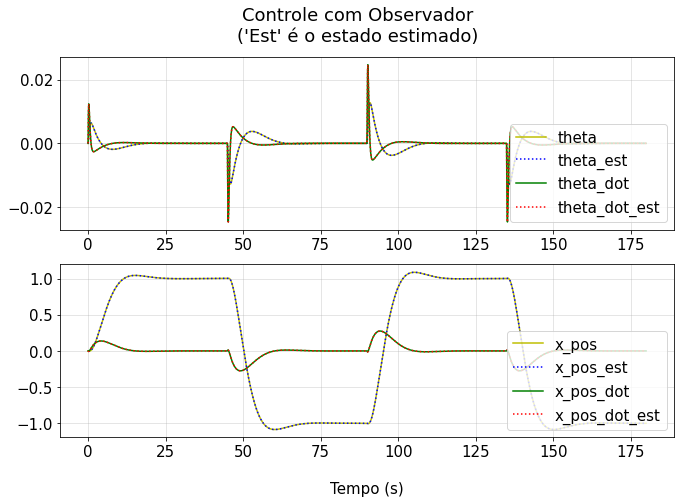

In [41]:
plota_obs(T, xout)

$$ $$
Acima vemos um bom desempenho do estimador já que as linhas tracejadas (estados estimados) se encontram em cima das linhas contínuas (estados reais).
$$ $$

$$ $$
# **Simulando o limite (θ inical) de controle**

Modelo abordado é linearizado para pequenos ângulos ($\theta$s) iniciais, tais como $sin(\theta)=\theta$, desta forma para grandes valores de $\theta$ o controle não deve responder bem.

Essa avaliação será feita agora.
$$ $$

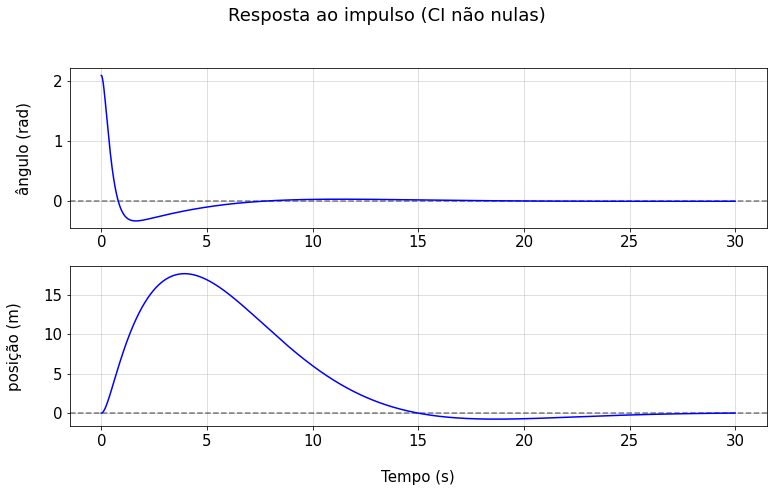

In [42]:

xo = [2.09, 0, 0, 0, 0, 0, 0, 0]

T, yout = impulse_response(sys_ss, T=t, X0=xo)

plota_resp_sist2(T, yout,
                 titulo='Resposta ao impulso (CI não nulas)',
                 ylabels=['ângulo (rad)', 'posição (m)'])


$$ $$
# **Simulação ponderando diferentes R e Q (LQR)**

Vamos variar aqui basicamente 3 parâmetros: $Q_{11}$, $Q_{33}$ e $R$.

A referência é mostrada abaixo.

$$ $$

In [43]:
parametros = [{'Q11':1,   'Q33':10,  'R':5},
              {'Q11':100, 'Q33':1,   'R':1},
              {'Q11':1,   'Q33':1,   'R':10},
              {'Q11':1,   'Q33':100, 'R':100},
              {'Q11':10,  'Q33':1,   'R':10},
              {'Q11':1,   'Q33':100, 'R':1}]

In [44]:
# parametros = [{'Q11':1,   'Q33':10,  'R':500},
#               {'Q11':1,   'Q33':100, 'R':100},
#               {'Q11':100,   'Q33':100, 'R':1}]

In [45]:
%%time

sistemas = Systems(parametros).run()


CPU times: user 56.7 ms, sys: 136 ms, total: 193 ms
Wall time: 60.3 ms


/home/carlos/Projetos/eng-controle-automacao/06_controle_avancado/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:127: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/carlos/Projetos/eng-controle-automacao/06_controle_avancado/.venv/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  return data.astype(dtype)


In [46]:
%%time

respostas = Responses(sistemas).run()


CPU times: user 2.26 s, sys: 2.29 s, total: 4.55 s
Wall time: 1.4 s


In [47]:
resp_df = TidyData(respostas).run()

In [48]:
viz = Visualizacao(resp_df)

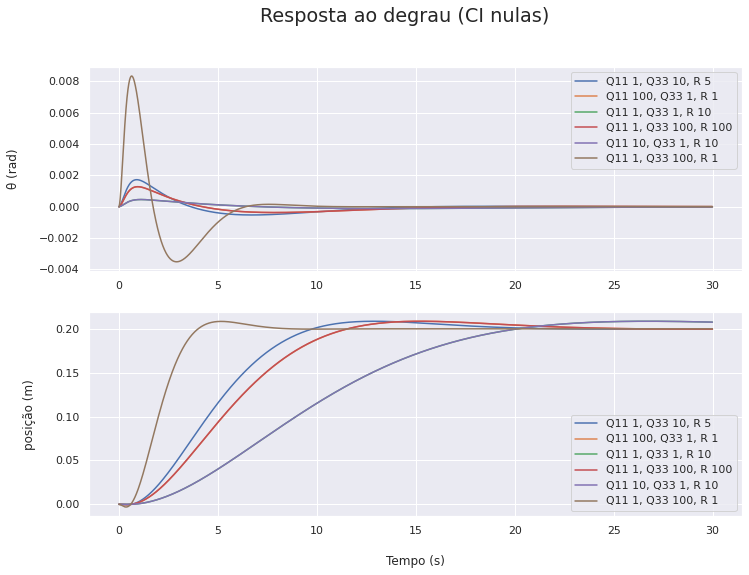

In [49]:
viz.set_param('step')
viz.show()

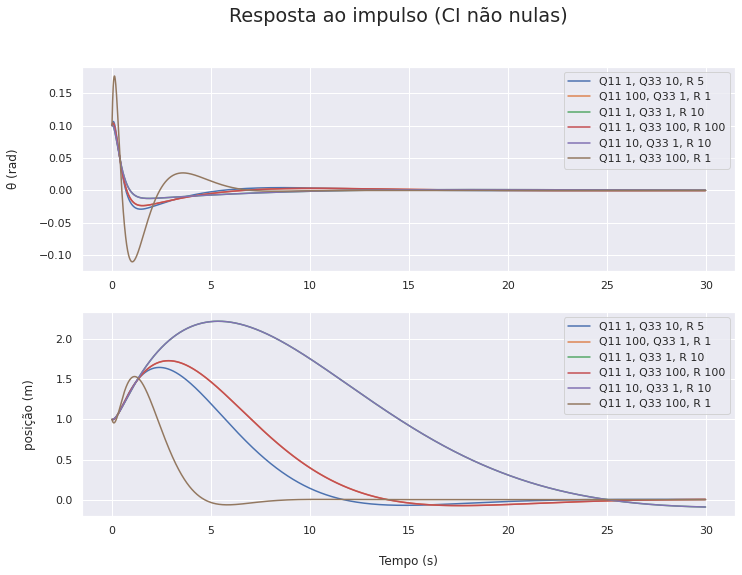

In [50]:
viz.set_param('ci')
viz.show()

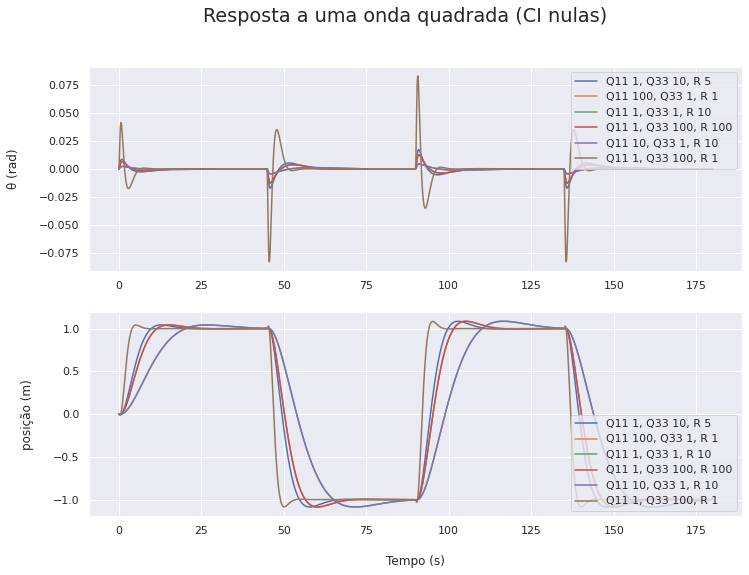

In [51]:
viz.set_param('wave')
viz.show()